In [23]:
from src.mitnanex import run
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [24]:

clusters_list = run()

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in clusters_list.clusters],
        "repr_read_len": [i.longest_read_length for i in clusters_list.clusters],
        "id_longest_read": [i.longest_read_id for i in clusters_list.clusters],
        "id_cluster":[i.id_cluster for i in clusters_list.clusters],
    }
)

In [25]:
# Test on the first 30 clusters
import math
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
82,5,34041,SRR5892449.10100,83
30,6,39243,SRR5892449.10138,31
927,2,14520,SRR5892449.10169,928
925,2,14557,SRR5892449.10171,926
563,4,19525,SRR5892449.10199,564


# Coverage

The first step is to filter the reads by coverage. For that I will explore the use of Kernel Density since this is clusters_list one dimensional clustering.

In [26]:
clusters['transform'] = [math.log2(i)for i in clusters['coverage']]
clusters.sort_values('coverage',ascending=False, inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster,transform
16,82,42906,SRR5892449.16013,17,6.357552
17,69,42640,SRR5892449.18856,18,6.108524
89,67,33518,SRR5892449.9739,90,6.066089
63,58,35773,SRR5892449.18969,64,5.857981
171,43,28741,SRR5892449.40354,172,5.426265


<Axes: >

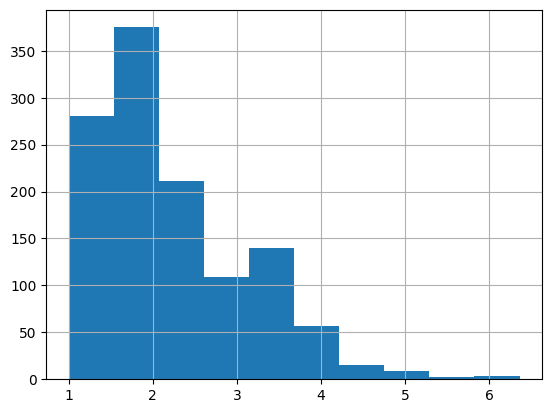

In [27]:
clusters['transform'].hist()

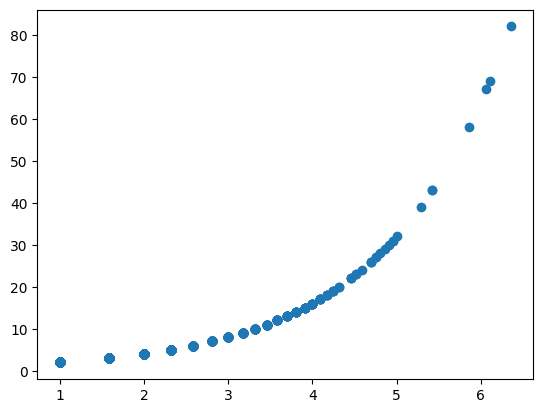

In [28]:
plt.scatter(x=clusters['transform'], y=clusters['coverage'])

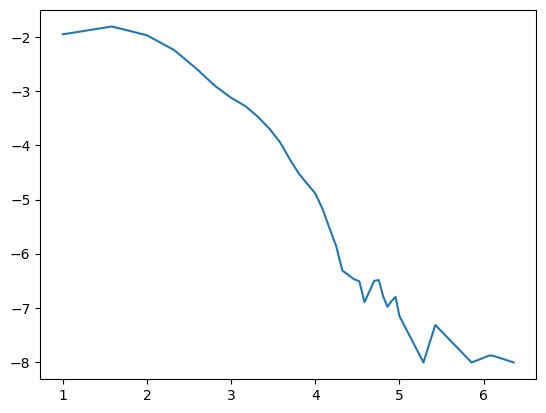

In [29]:
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(clusters['coverage'].array.reshape(-1,1))
cov_fdp = kde.score_samples(clusters['coverage'].array.reshape(-1,1))
plt.plot(clusters['transform'], cov_fdp)

In [30]:
from scipy.signal import argrelextrema
import numpy as np
local_min = argrelextrema(cov_fdp, np.less)[0]
min_coverage = clusters.iloc[max(local_min),:]['coverage']
print("Covertura minima admitida: ", min_coverage)

Covertura minima admitida:  24


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create clusters_list script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [31]:
from src.utils import get_sequences_by_id, convert_fq_to_fa, write_fasta
from src.kmer_cnt import count_kmer

In [32]:
convert_fq_to_fa('test/s_cervisae_CEN_PK113-7D_SRR5892449_reads_sample.sorted.fastq','test/s_cervisae_CEN_PK113-7D_SRR5892449_reads_sample.sorted.fasta')

23278 sequences converted to fasta


'test/s_cervisae_CEN_PK113-7D_SRR5892449_reads_sample.sorted.fasta'

In [33]:
fasta = 'test/s_cervisae_CEN_PK113-7D_SRR5892449_reads_sample.sorted.fasta'
repr_reads = [i for i in clusters['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [34]:
## Get the real mt sequences
with open('test/list_ids_reads_mt.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[1:] for i in ids_mt]

In [35]:
hist_df= pd.DataFrame(hist)
hist_df.rename(columns={hist_df.iloc[:,-1].name:'ids'}, inplace=True)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,ids
0,0.059220,0.048021,0.038510,0.040575,0.044750,0.035360,0.036852,0.037320,0.029844,0.028125,...,0.016263,0.022744,0.016369,0.043831,0.023799,0.029271,0.028050,0.019775,0.023724,SRR5892449.12156
1,0.065132,0.059893,0.038992,0.041494,0.048708,0.037270,0.039065,0.038648,0.030835,0.025197,...,0.011130,0.019795,0.012399,0.048074,0.021082,0.030255,0.023656,0.014266,0.021481,SRR5892449.7189
2,0.068673,0.062148,0.036930,0.042465,0.053846,0.038121,0.039734,0.035885,0.030479,0.022378,...,0.010410,0.018492,0.010923,0.048458,0.018804,0.028591,0.024485,0.014772,0.022030,SRR5892449.19157
3,0.071805,0.062768,0.040806,0.043588,0.050869,0.039306,0.040510,0.037886,0.030348,0.022514,...,0.009748,0.018962,0.009748,0.049902,0.019495,0.027822,0.022869,0.012352,0.021074,SRR5892449.5164
4,0.064267,0.054721,0.036237,0.043143,0.043793,0.031849,0.039324,0.036054,0.031037,0.026223,...,0.014665,0.020190,0.013406,0.048525,0.023460,0.029757,0.028031,0.019032,0.022181,SRR5892449.19870


# Dimensionality reduction with PCA and clustering with k-means 

In [36]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [37]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [38]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([1.19915919e-03, 6.63358065e-05])

In [39]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction, columns=['comp1', 'comp2'])

## merging the dataframe with ids and other relevant information
kmer_reduction ['ids'] = hist_df['ids']
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
kmer_reduction['mt'] = (kmer_reduction['ids'].isin(ids_mt).astype(int) + 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage'] > min_coverage]
kmer_reduction

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt
16,0.249961,0.018859,SRR5892449.16013,82,42906,17,6.357552,32
17,0.194803,-0.002892,SRR5892449.18856,69,42640,18,6.108524,32
63,0.223506,0.003260,SRR5892449.18969,58,35773,64,5.857981,32
71,0.205763,0.003661,SRR5892449.29678,30,35245,72,4.906891,32
80,0.247855,0.004846,SRR5892449.12370,26,34143,81,4.700440,32
81,0.001319,-0.000911,SRR5892449.45877,39,34069,82,5.285402,1
89,0.118808,0.016357,SRR5892449.9739,67,33518,90,6.066089,32
98,0.241503,0.004830,SRR5892449.22604,28,32839,99,4.807355,32
107,-0.014169,0.012609,SRR5892449.36049,31,32255,108,4.954196,1
111,0.001006,-0.005880,SRR5892449.37875,29,31943,112,4.857981,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'comp2')

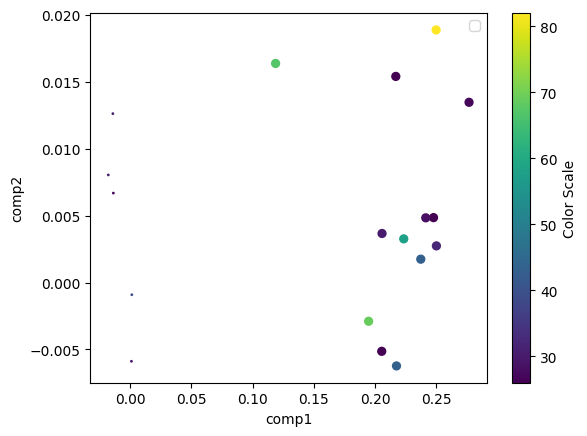

In [40]:
sc = plt.scatter(kmer_reduction['comp1'],kmer_reduction['comp2'], c=kmer_reduction['coverage'], s=kmer_reduction['mt'])
# legend
# Add clusters_list colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()
plt.xlabel('comp1')
plt.ylabel('comp2')

In [41]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
mt_prediction = kmeans.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
kmer_reduction['cluster_prediction'] = mt_prediction

Initialization complete
Iteration 0, inertia 0.021790841115488117.
Iteration 1, inertia 0.019206422145011608.
Converged at iteration 1: strict convergence.


Text(0, 0.5, 'comp2')

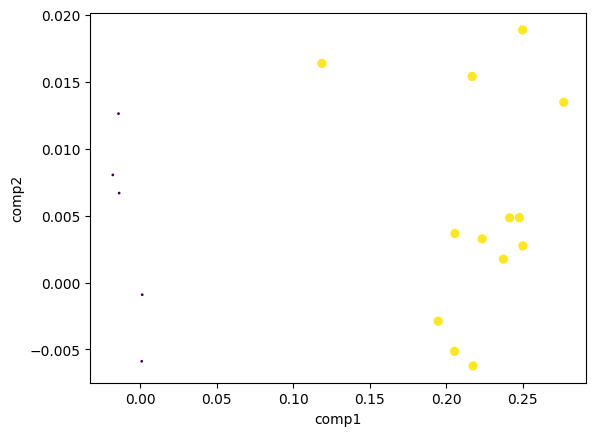

In [42]:
plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=kmer_reduction['mt'])
plt.xlabel('comp1')
plt.ylabel('comp2')

# Get the cluster of interest

This step is clusters_list pain in the ass, but since I am looking to keep the free-reference. 

In [43]:
selected_cluster_id = kmer_reduction.loc[:, kmer_reduction.columns != 'ids'].groupby(by='cluster_prediction')['coverage'].median().idxmax()
selected_cluster = kmer_reduction[kmer_reduction['cluster_prediction'] == selected_cluster_id]
selected_cluster.sort_values('coverage')

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt,cluster_prediction
80,0.247855,0.004846,SRR5892449.12370,26,34143,81,4.700440,32,1
282,0.217009,0.015387,SRR5892449.25665,26,24448,283,4.700440,32,1
342,0.205521,-0.005137,SRR5892449.45137,26,23165,343,4.700440,32,1
349,0.276859,0.013455,SRR5892449.45685,27,23009,350,4.754888,32,1
98,0.241503,0.004830,SRR5892449.22604,28,32839,99,4.807355,32,1
71,0.205763,0.003661,SRR5892449.29678,30,35245,72,4.906891,32,1
676,0.250193,0.002735,SRR5892449.35780,32,18126,677,5.000000,32,1
171,0.237428,0.001742,SRR5892449.40354,43,28741,172,5.426265,32,1
338,0.217575,-0.006228,SRR5892449.36605,43,23206,339,5.426265,32,1
63,0.223506,0.003260,SRR5892449.18969,58,35773,64,5.857981,32,1


In [44]:
sequences_ids = set()
for i in selected_cluster['id_cluster']:
    sequences_ids.update(clusters_list.get_cluster(i).id_sequences)
write_fasta(fasta=fasta, sequences_ids=sequences_ids, output='test/mt_reads_v1.fasta')

557 reads retrieved
